# Online Shopping Intent - Modeling 
**Tony Ghabour**
___

# Initial Setup

## Dependencies

In [1]:
# General Tools
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from time import strptime

# Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier

#Classification Model Tools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split#, learning_curve
from imblearn.over_sampling import RandomOverSampler#, SMOTE, ADASYN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Import processed data for modeling.**

In [3]:
online_df = pd.read_csv('online_shopping_for_models.csv')

In [4]:
online_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BounceRates         12330 non-null  float64
 1   PageValues          12330 non-null  float64
 2   SpecialDay          12330 non-null  float64
 3   Month               12330 non-null  int64  
 4   Weekend             12330 non-null  int64  
 5   Revenue             12330 non-null  int64  
 6   tot_pages           12330 non-null  int64  
 7   pct_admin           12330 non-null  float64
 8   pct_info            12330 non-null  float64
 9   pct_prod            12330 non-null  float64
 10  tot_duration        12330 non-null  float64
 11  pct_admin_dur       12330 non-null  float64
 12  pct_info_dur        12330 non-null  float64
 13  pct_prod_dur        12330 non-null  float64
 14  avg_page_value      12330 non-null  float64
 15  OperatingSystems_2  12330 non-null  int64  
 16  Oper

## Functions

### Confusion Matrix
**Automate process for producing confusion matrix with respect to the test set.**

In [5]:
def show_cm(single_model):
    """
    Generates confusion matrix with respect to the test set, for a given classification model definition.
    """
    name, model = single_model
    model.fit(X_train, y_train)
    model_cm = confusion_matrix(y_test, model.predict(X_test), labels = None)

    plt.figure(figsize=(5, 5))
    plt.title(f'Confusion Matrix: {name}', fontsize= 17)
    plt.tick_params(axis='both', which='major')#, pad=10)
   
    ticks =['No Purchase', 'Purchase']
    
    sns.set(font_scale=1.3)
    sns.heatmap(model_cm, annot = True, cmap="Blues", fmt='g', 
                cbar = False, xticklabels = ticks, yticklabels = ticks, annot_kws={"size": 14})
    
    plt.yticks(va="center")
    plt.ylabel("ACTUAL", fontsize = 14, labelpad = 12)
    plt.xlabel("PREDICTED", fontsize = 14, labelpad = 12)
    
    plt.show()
    print('\n')

### Model Metrics
**Automate process for returning relevant scores/metrics accross multiple models.**

In [6]:
def get_scores(list_of_models):

    scores = {}

    for model_tuple in list_of_models:
        name, model = model_tuple
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        scores[name] = {
            'Accuracy' : accuracy,
            'Precision' : precision,
            'Recall' : recall,
            'F1' : f1,
            "AUC": auc
        }

    df = pd.DataFrame(scores)
    return df

### Plot ROC Curves
**Automate process for plotting ROC curves accross multiple models.**

In [7]:
def plot_roc(models):
    
    roc_curve_data = []

    for name, classifier in models:

        fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
        roc_curve_data.append([name, fpr, tpr])

    plt.figure(figsize=(8,8))

    for name, fpr, tpr in roc_curve_data:
        plt.plot(fpr, tpr, lw=2, label=name, alpha=.7)

    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves')
    plt.legend();

# Modeling

## Prepare Final Data

**Split Data into train and test sets.**

In [8]:
y = online_df["Revenue"]
X = online_df.drop(columns = ['Revenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

**Apply Standard Scaler, since some models will be based on Euclidean distance (e.g., k-NN).**

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Dummy Classifiers

Let's begin by establishing two simple/dummy "baseline" models. These models will help us evaluate the extent to which more sophisticated models are or are not able to identify underlying systematic/predictive patterns inherent in the data.

In [10]:
dummy_1 = DummyClassifier(strategy = 'stratified')
dummy_2 = DummyClassifier(strategy = 'constant', constant = 1)

dummy_models = ([("Dummy (stratified)", dummy_1), 
                 ("Dummy (majority)"  , dummy_2)])

**Review standard metrics/scores.**

In [11]:
get_scores(dummy_models)

,Dummy (stratified),Dummy (majority)
Accuracy,0.733441,0.153285
Precision,0.127886,0.153285
Recall,0.126984,1.000000
F1,0.127434,0.265823
AUC,0.507222,0.500000


**Review applicable confusion matrix for each model.**

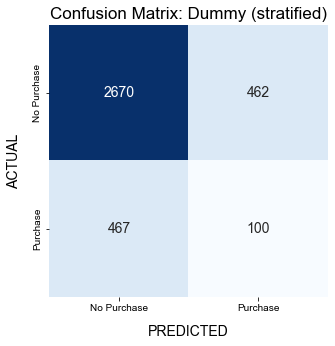

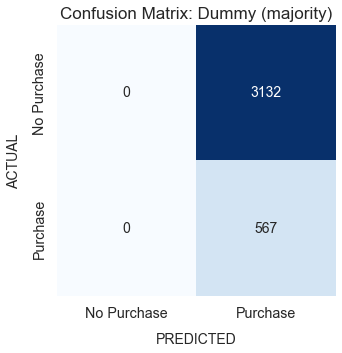

In [12]:
for model in dummy_models:
    show_cm(model)

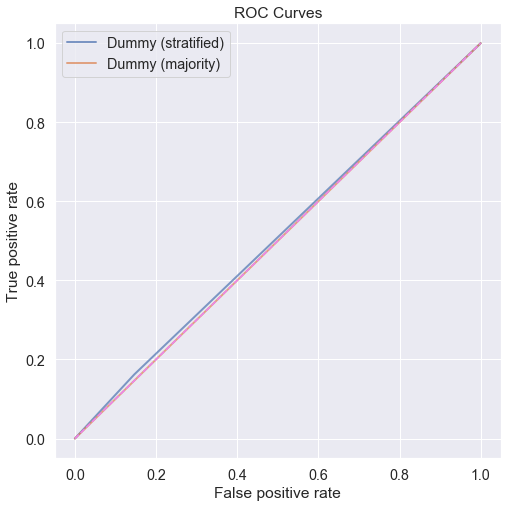

In [13]:
plot_roc(dummy_models)

## k-Nearest Neighbors

In [14]:
knn_models = []
for k in range(1, 10):
    model_name = f'k-NN (k={k})'
    knn_models.append((model_name, KNeighborsClassifier(n_neighbors = k)))

In [15]:
get_scores(knn_models)

,k-NN (k=1),k-NN (k=2),k-NN (k=3),k-NN (k=4),k-NN (k=5),k-NN (k=6),k-NN (k=7),k-NN (k=8),k-NN (k=9)
Accuracy,0.827791,0.855907,0.857529,0.861314,0.859421,0.860773,0.862666,0.862666,0.866180
Precision,0.427386,0.595506,0.564935,0.662651,0.600858,0.671053,0.652850,0.732283,0.725000
Recall,0.363316,0.186949,0.306878,0.194004,0.246914,0.179894,0.222222,0.164021,0.204586
F1,0.392755,0.284564,0.397714,0.300136,0.350000,0.283727,0.331579,0.268012,0.319120
AUC,0.637597,0.694998,0.712975,0.726867,0.734441,0.739125,0.740483,0.740080,0.745619


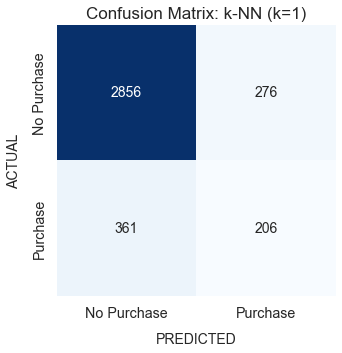

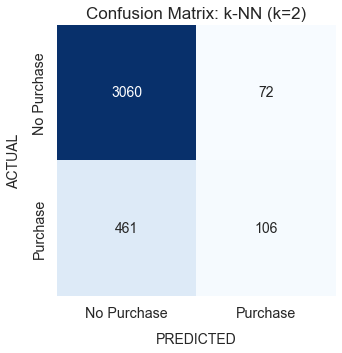

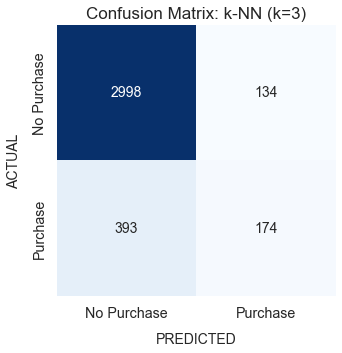

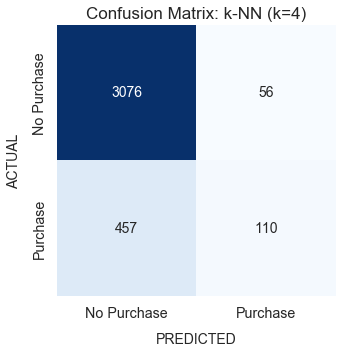

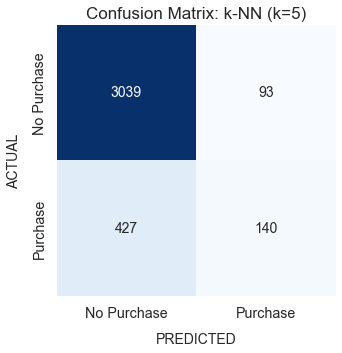

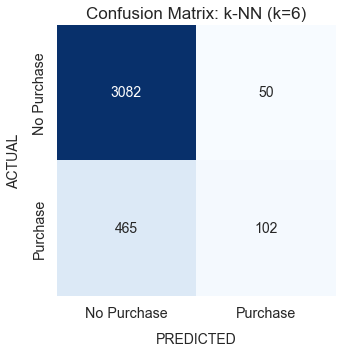

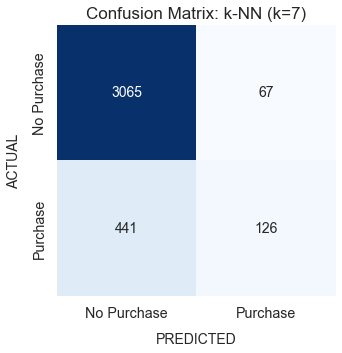

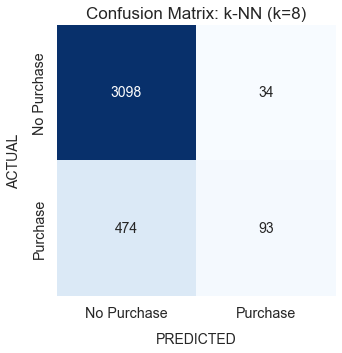

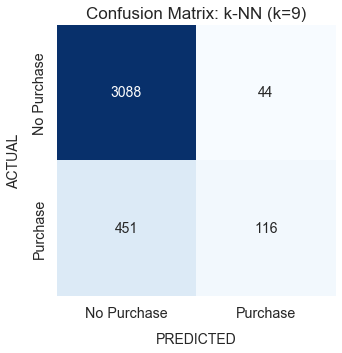

In [16]:
for model in knn_models:
    show_cm(model)

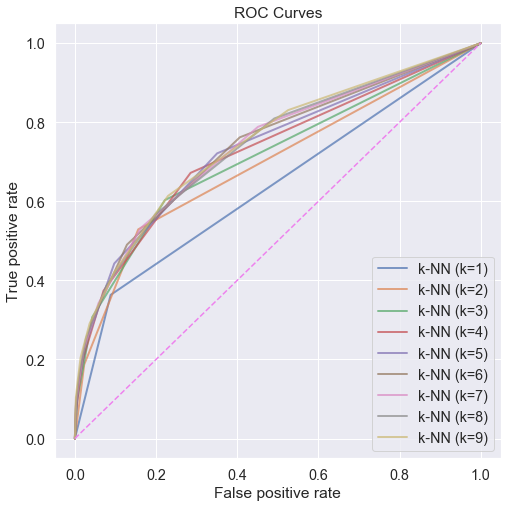

In [17]:
plot_roc(knn_models)

## Logistic Regression

In [18]:
lr_models = []

lr_1 = LogisticRegression(C = .001)
lr_2 = LogisticRegression(C = .01)
lr_3 = LogisticRegression(C = .1)
lr_4 = LogisticRegression(C = 1)

lr_1b = LogisticRegression(C = .001, class_weight = 'balanced')
lr_2b = LogisticRegression(C = .01,  class_weight = 'balanced')
lr_3b = LogisticRegression(C = .1,   class_weight = 'balanced')
lr_4b = LogisticRegression(C = 1,    class_weight = 'balanced')

lr_models = [('lr_1', lr_1),
             ('lr_2', lr_2),
             ('lr_3', lr_3),
             ('lr_4', lr_4),
             ('lr_1b', lr_1b),
             ('lr_2b', lr_2b),
             ('lr_3b', lr_3b),
             ('lr_4b', lr_4b)]

In [19]:
get_scores(lr_models)

,lr_1,lr_2,lr_3,lr_4,lr_1b,lr_2b,lr_3b,lr_4b
Accuracy,0.870235,0.881049,0.886456,0.886456,0.841849,0.857259,0.862125,0.861855
Precision,0.848000,0.757085,0.765343,0.761566,0.488916,0.525097,0.536680,0.536082
Recall,0.186949,0.329806,0.373898,0.377425,0.700176,0.719577,0.735450,0.733686
F1,0.306358,0.459459,0.502370,0.504717,0.575780,0.607143,0.620536,0.619509
AUC,0.881688,0.887609,0.887989,0.887853,0.883934,0.896313,0.899613,0.899998


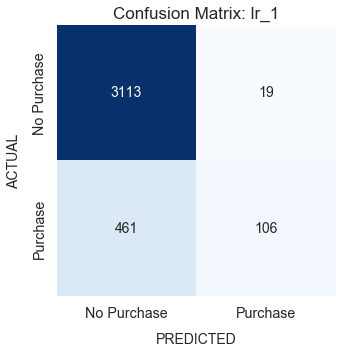

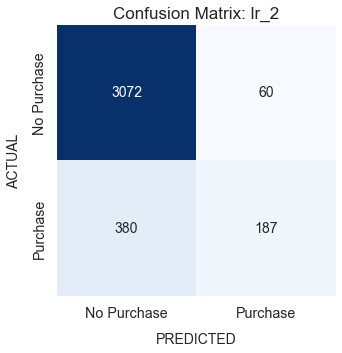

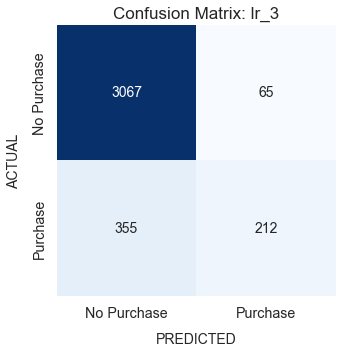

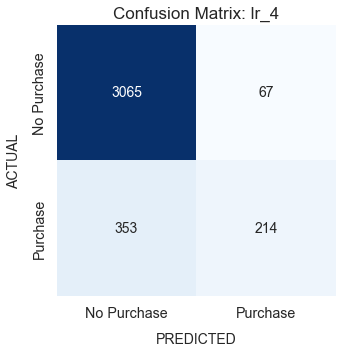

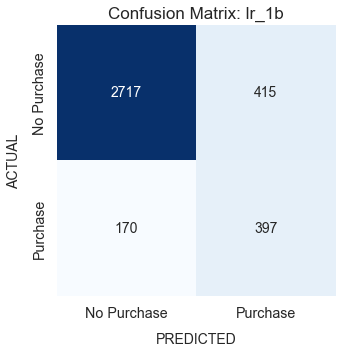

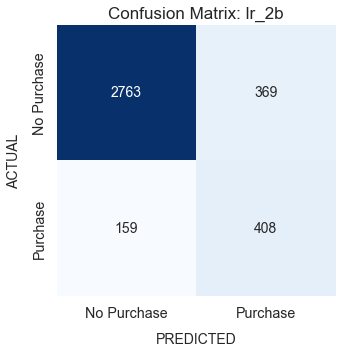

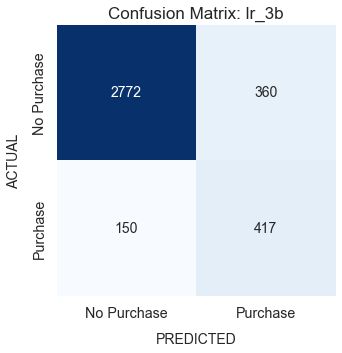

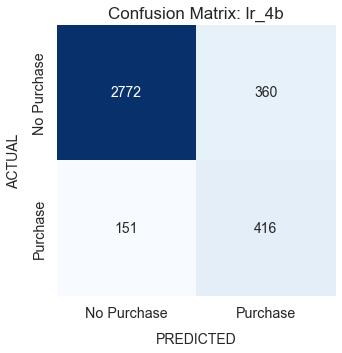

In [20]:
for model in lr_models:
    show_cm(model)

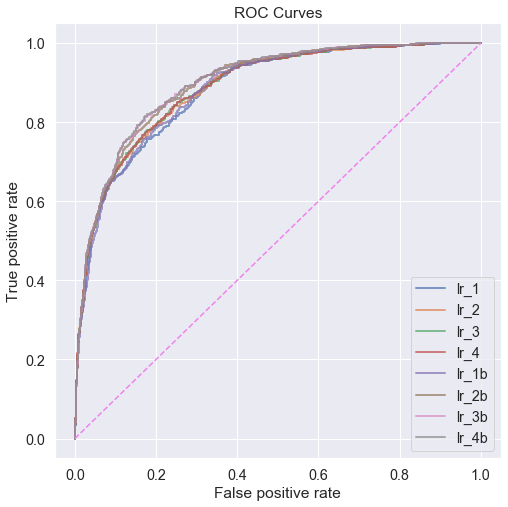

In [21]:
plot_roc(lr_models)

## Naive Bayes

In [22]:
nb_1 = ('nb_1 (normal)', GaussianNB())
nb_2 = ('nb_3 (bernoulli, fit)', BernoulliNB(fit_prior = True))
nb_3 = ('nb_3 (bernoulli, no fit)', BernoulliNB(fit_prior = False))

nb_models = [nb_1, nb_2, nb_3]

In [23]:
get_scores(nb_models)

,nb_1 (normal),"nb_3 (bernoulli, fit)","nb_3 (bernoulli, no fit)"
Accuracy,0.250338,0.886726,0.843742
Precision,0.167571,0.624161,0.493771
Recall,0.980600,0.656085,0.768959
F1,0.286229,0.639725,0.601379
AUC,0.623004,0.885837,0.885837


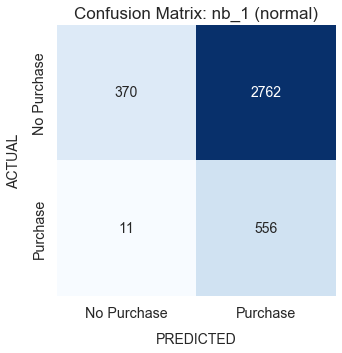

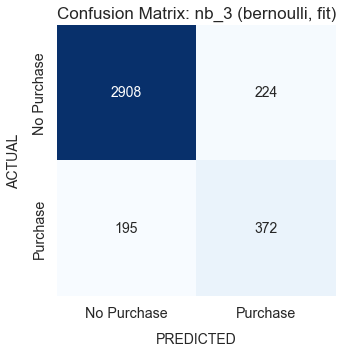

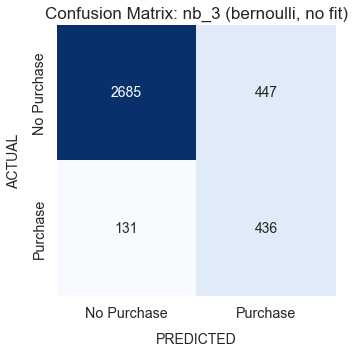

In [24]:
for model in nb_models:
    show_cm(model)

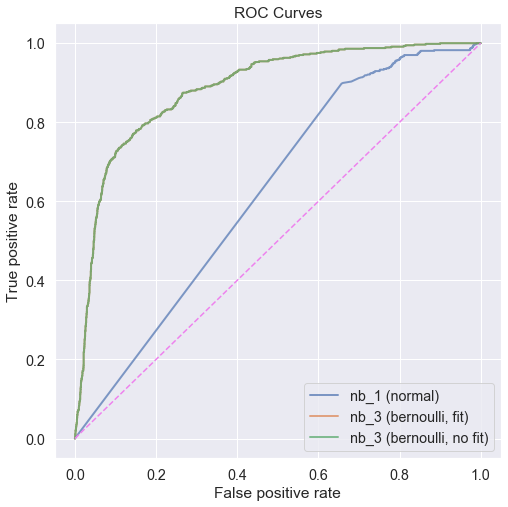

In [25]:
plot_roc(nb_models)

## Decision Trees

In [26]:
#dt_1 = DecisionTreeClassifier()
#dt_2 = DecisionTreeClassifier(max_depth = 5)
#dt_3 = DecisionTreeClassifier(max_depth = 10)

# dt_1 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best')
# dt_2 = DecisionTreeClassifier(criterion = 'gini', splitter = 'random')
# dt_3 = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best')
# dt_4 = DecisionTreeClassifier(criterion = 'entropy', splitter = 'random')

dt_1 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5)
dt_2 = DecisionTreeClassifier(criterion = 'gini', splitter = 'random', max_depth = 5)
dt_3 = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 5)
dt_4 = DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_depth = 5)

dt_5 = DecisionTreeClassifier(class_weight= 'balanced', 
                            max_depth= 5, 
                            max_features= 'log2',
                            max_leaf_nodes= 10,
                            min_samples_leaf= 50,
                            min_samples_split= 5)

dt_6 = DecisionTreeClassifier(class_weight= None, 
                            max_depth= None, 
                            max_features= None, 
                            max_leaf_nodes= None,
                            min_samples_leaf= 1,
                            min_samples_split= 25)


In [27]:
dt_models = [('dt_1', dt_1),
             ('dt_2', dt_2),
             ('dt_3', dt_3),
             ('dt_4', dt_4),
             ('dt_5', dt_5),
             ('dt_6', dt_6)]

In [28]:
get_scores(dt_models)

,dt_1,dt_2,dt_3,dt_4,dt_5,dt_6
Accuracy,0.900784,0.888889,0.898892,0.892674,0.861044,0.880508
Precision,0.677305,0.672566,0.706638,0.647059,0.530355,0.620424
Recall,0.673721,0.536155,0.582011,0.659612,0.816578,0.567901
F1,0.675508,0.596663,0.638298,0.653275,0.643056,0.593002
AUC,0.922307,0.859085,0.920624,0.904449,0.885001,0.853862


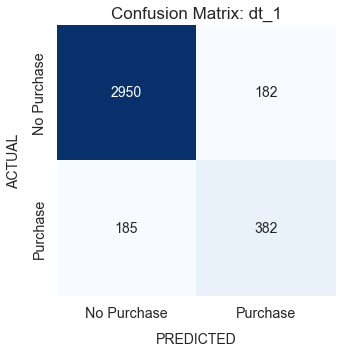

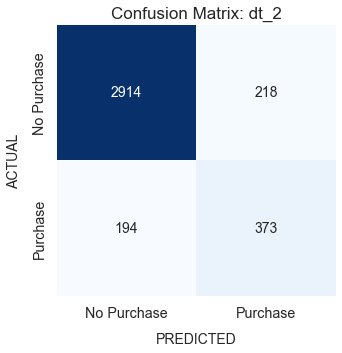

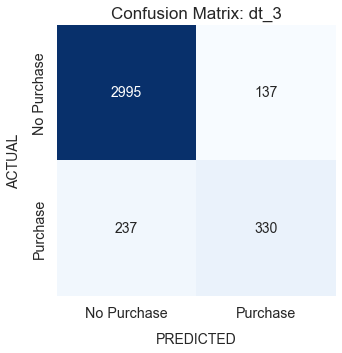

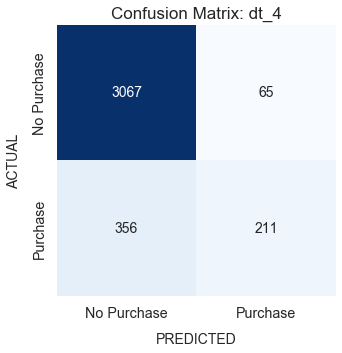

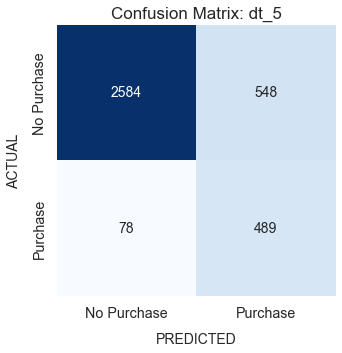

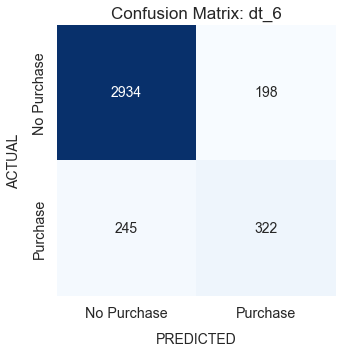

In [29]:
for model in dt_models:
    show_cm(model)

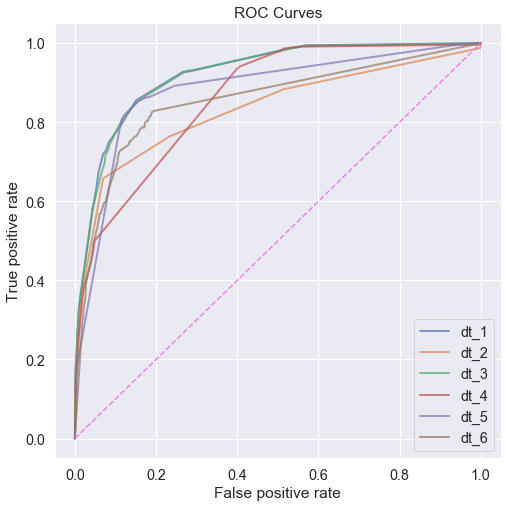

In [30]:
plot_roc(dt_models)

## Random Forests

In [31]:
rf_1 = RandomForestClassifier(n_estimators=100, 
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_features=None, 
                              max_leaf_nodes=None)
rf_2 = RandomForestClassifier(n_estimators=100, 
                              max_depth=50, 
                              min_samples_split=5, 
                              min_samples_leaf=2, 
                              max_features='auto', 
                              max_leaf_nodes=None)
rf_3 = RandomForestClassifier(n_estimators=100, 
                              max_depth=50, 
                              min_samples_split=10, 
                              min_samples_leaf=5, 
                              max_features='auto', 
                              max_leaf_nodes=None)
rf_4 = RandomForestClassifier(n_estimators=100, 
                              max_depth=25, 
                              min_samples_split=20, 
                              min_samples_leaf=10, 
                              max_features='auto', 
                              max_leaf_nodes=None)
rf_5 = RandomForestClassifier(n_estimators=100, 
                              max_depth=10, 
                              min_samples_split=25, 
                              min_samples_leaf=10, 
                              max_features='log2', 
                              max_leaf_nodes=None)
rf_6 = RandomForestClassifier(n_estimators = 100, 
                              class_weight= 'balanced', 
                              max_depth= 50, 
                              max_features= 'log2',
                              max_leaf_nodes= 10,
                              min_samples_leaf= 50,
                              min_samples_split= 5)

rf_models = [('rf_1', rf_1),
             ('rf_2', rf_2),
             ('rf_3', rf_3),
             ('rf_4', rf_4),
             ('rf_5', rf_5),
             ('rf_6', rf_6)]

In [32]:
get_scores(rf_models)

,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6
Accuracy,0.898081,0.901865,0.901054,0.901595,0.900514,0.869424
Precision,0.695473,0.732877,0.729977,0.734411,0.775623,0.550239
Recall,0.596120,0.566138,0.562610,0.560847,0.493827,0.811287
F1,0.641975,0.638806,0.635458,0.636000,0.603448,0.655738
AUC,0.922719,0.928038,0.929902,0.930157,0.924358,0.898820


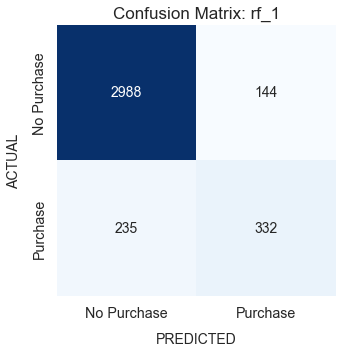

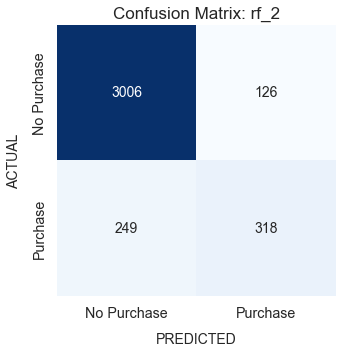

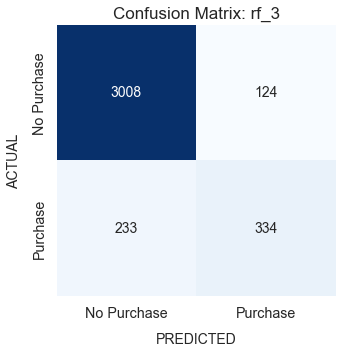

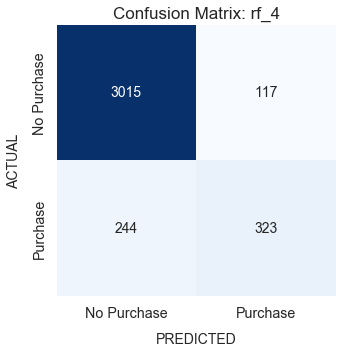

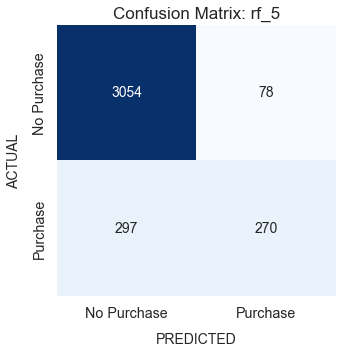

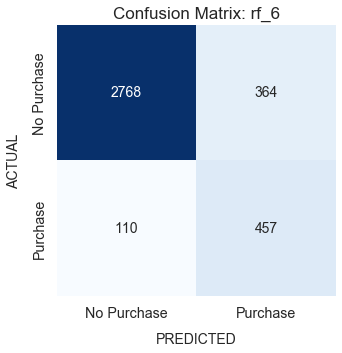

In [33]:
for model in rf_models:
    show_cm(model)

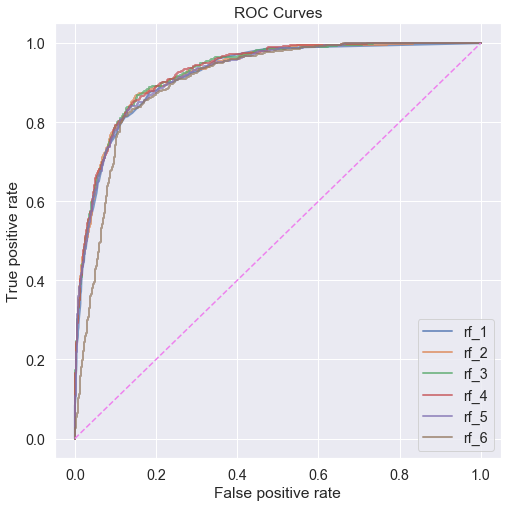

In [34]:
plot_roc(rf_models)

# Ensemble Models

**Pick selected models for ensembling**

In [35]:
ensemble = lr_models[1:4] + [nb_models[2]] + dt_models[0:4] + rf_models[0:4]

In [36]:
get_scores(ensemble)

,lr_2,lr_3,lr_4,"nb_3 (bernoulli, no fit)",dt_1,dt_2,dt_3,dt_4,rf_1,rf_2,rf_3,rf_4
Accuracy,0.881049,0.886456,0.886456,0.843742,0.900784,0.889970,0.898892,0.894025,0.898892,0.903217,0.902406,0.902676
Precision,0.757085,0.765343,0.761566,0.493771,0.677305,0.746914,0.706638,0.749288,0.706638,0.731707,0.729911,0.737931
Recall,0.329806,0.373898,0.377425,0.768959,0.673721,0.426808,0.582011,0.463845,0.582011,0.582011,0.576720,0.566138
F1,0.459459,0.502370,0.504717,0.601379,0.675508,0.543210,0.638298,0.572985,0.638298,0.648330,0.644335,0.640719
AUC,0.887609,0.887989,0.887853,0.885837,0.922307,0.859306,0.920624,0.845238,0.923061,0.927710,0.929793,0.928929


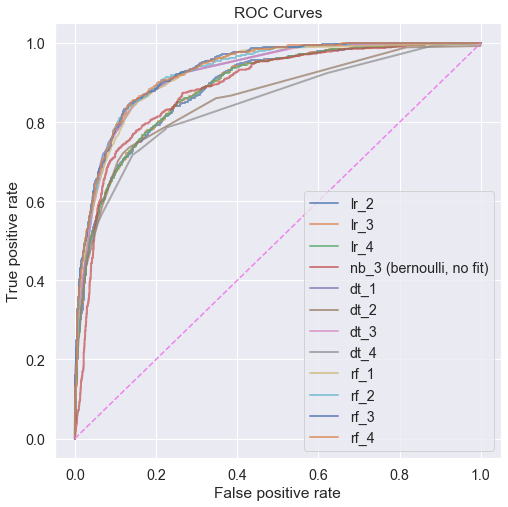

In [37]:
plot_roc(ensemble)

## Stacking & Voting Classifiers

In [38]:
stc = ('stc', StackingClassifier(estimators=ensemble, final_estimator=LogisticRegression(solver = 'liblinear')))

vc_1 = ('votes (soft)', VotingClassifier(estimators=ensemble, voting='soft'))
vc_2 = ('votes (hard)', VotingClassifier(estimators=ensemble, voting='hard'))

In [39]:
ens_models = [stc, vc_1, vc_2]

In [40]:
get_scores(ens_models[0:2])

,stc,votes (soft)
Accuracy,0.902676,0.897810
Precision,0.719745,0.740458
Recall,0.597884,0.513228
F1,0.653179,0.606250
AUC,0.928508,0.928649


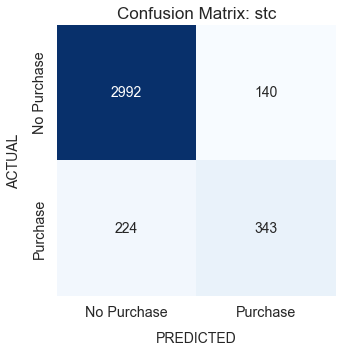

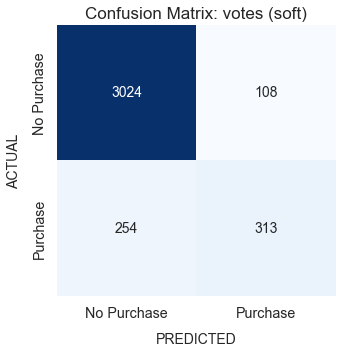

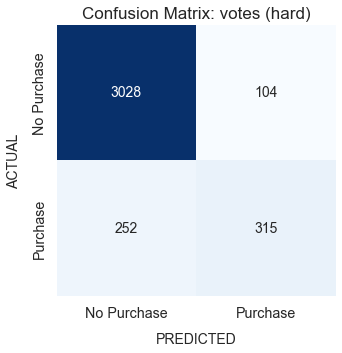

In [41]:
for model in ens_models:
    show_cm(model)

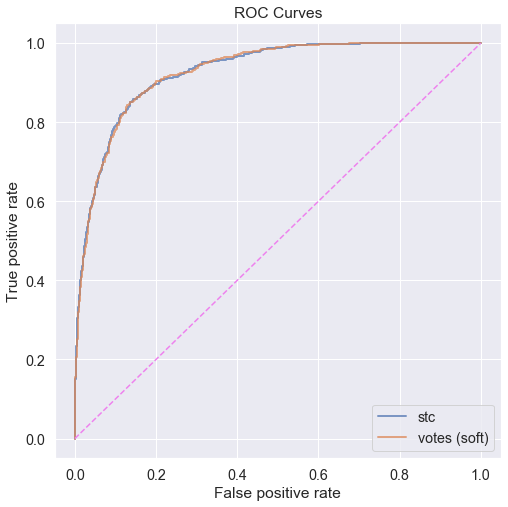

In [42]:
plot_roc(ens_models[0:2])

# Interactive Visualization

## Data Setup

Interactive visualization will incorporate raw features not explicitly included in modeling, so let's start with a clean dataframe of our raw data and and grab the class labels from the test set.

In [43]:
online_raw = pd.read_csv('online_shoppers_intention.csv')
plot_data = pd.DataFrame({'y_test': y_test})

Visualization will rely on final predicted probabilities, based on test set data only.  
Grab the predicted probabilities from our final model with respect to the test set.

In [44]:
#Include engineered features in case used in modeling
plot_data = plot_data.join(online_df.loc[plot_data.index.values])
plot_data['vc_1'] = vc_1[1].predict_proba(X_test)[:,1]

cols_to_use = online_raw.columns.difference(plot_data.columns)
plot_data = pd.concat([plot_data, online_raw[cols_to_use]], axis=1, join = 'inner')
plot_data['Revenue'] = plot_data.Revenue.astype(bool)

Aggregate administrative page data based on ProductRelated page views.

In [45]:
admin = plot_data.groupby(['Administrative', 'y_test', 'VisitorType']).ProductRelated.sum()
admin = online_raw.groupby(['Administrative', 'Revenue', 'VisitorType']).ProductRelated.sum().reset_index()
admin_df = pd.DataFrame(admin)

Merge aggregated administrative page data into plotting dataframe

In [46]:
plot_data = pd.merge(plot_data, admin_df,  how='left', 
                     left_on=['Administrative', 'Revenue', 'VisitorType'], 
                     right_on = ['Administrative', 'Revenue', 'VisitorType'])

plot_data = plot_data.rename(columns={'ProductRelated_x': 'ProductRelated', 'ProductRelated_y': "admin_prod_sum"})

In [47]:
plot_data['Revenue'] = plot_data.Revenue.astype(bool).astype(str)

Apply a few contraints to ignore outliers.  This won't affect overall messaging or conclusions derived from visualization, but helps with scaling.

In [48]:
plot_data = plot_data[plot_data.admin_prod_sum < 50000]
plot_data = plot_data[plot_data.VisitorType != 'Other']

Truncate VisitorType to eliminate the word "Visitor" ("New/Returning" alone are sufficient in context).

In [49]:
plot_data['VisitorType'] = plot_data.VisitorType.transform(lambda x: x[:-8])
plot_data['VisitorType'].head()

1          New
2    Returning
4          New
7    Returning
8    Returning
Name: VisitorType, dtype: object

Combine VisitorType with target label ("Purchase" or "No Purchase") to create four distinct groups for plotting.

In [50]:
plot_data.loc[(plot_data.Revenue == 'True'),'Revenue']='Purchase'
plot_data.loc[(plot_data.Revenue == 'False'),'Revenue']='NO Purchase'
plot_data['legend'] = plot_data.VisitorType + ' - ' + plot_data['Revenue']
plot_data.legend.head()

1          New - NO Purchase
2       Returning - Purchase
4          New - NO Purchase
7    Returning - NO Purchase
8    Returning - NO Purchase
Name: legend, dtype: object

## Plotting

In [51]:
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, factor_mark

In [52]:
output_file("online_shopping.html")
output_notebook() 
    
# Set up values/variables that will define figures and plots below
source = plot_data
source = ColumnDataSource(data=dict(plot_data))

VisitorType = ['Returning_Visitor', 'New_Visitor']
LEGEND = ['Returning - Purchase', 'New - Purchase', 'New - NO Purchase', 'Returning - NO Purchase']
MARKERS = ['circle','square', 'square', 'circle']

TOOLS1 = "pan,box_zoom,reset,box_select,lasso_select, tap, save, zoom_in, zoom_out" 
TOOLS2 = "pan,box_zoom,reset,box_select,lasso_select, tap, save, zoom_in, zoom_out, hover" 

TOOLTIPS = [
    ("Visitor Type", "@VisitorType"), 
    ("Puchase Probability", '@sc_1'), 
    ("Actual Outcome", '@Revenue')
]

index_cmap = factor_cmap('Revenue', 
                         palette=['tomato', 'steelblue'], 
                         factors=sorted(plot_data.Revenue.unique()))

# Define left figure
left = figure(tools=TOOLS1, plot_width=600, plot_height=600, 
              title='Aggregate Product Related Page Views (by Visitor Type)')

# Define right figure
right = figure(tools=TOOLS2, plot_width=600, plot_height=600, tooltips=TOOLTIPS, 
               title='Predicted Probability of Purchase', x_range=left.x_range)

# Define scatter plot for left figure 
left.scatter('Administrative', 'admin_prod_sum', 
             source=source, 
             size = 10, 
             fill_alpha=.1, 
             nonselection_line_color='lightgray',  
             nonselection_fill_color='lightgray', 
             legend_field='legend', 
             marker=factor_mark('legend', MARKERS, LEGEND), 
             color=index_cmap)

# Define scatter plot for right figure 
right.scatter('Administrative', 'vc_1', 
              source=source, 
              size = 10, 
              fill_alpha=.1,
              nonselection_line_color='lightgray',  
              nonselection_fill_color='lightgray',
              marker=factor_mark('legend', MARKERS, LEGEND), 
              color=index_cmap)

# Formatting
left.min_border = 30
right.min_border = 30

left.title.text_font_size = '12pt'
right.title.text_font_size = '12pt'

left.legend.border_line_width = 0
left.legend.background_fill_alpha = 0.0

left.background_fill_color = "ghostwhite"
right.background_fill_color = "ghostwhite"

left.xaxis.axis_label = 'Administrative Pages Viewed'
left.yaxis.axis_label = 'Total Product Related Pages'

right.xaxis.axis_label = 'Administrative Pages Viewed'
right.yaxis.axis_label = 'Probability of Purchase'

p = gridplot([[left, right]])

show(p)

Loading BokehJS ...